In [28]:
import os
import numpy
from numpy import random
import scipy
from scipy.special import softmax
import mnist
import pickle

# you can use matplotlib for plotting
from time import time
import matplotlib
from matplotlib import pyplot

mnist_data_directory = os.path.join(os.path.abspath(''), "data")

# TODO add any additional imports and global variables


def load_MNIST_dataset():
    PICKLE_FILE = os.path.join(mnist_data_directory, "MNIST.pickle")
    try:
        dataset = pickle.load(open(PICKLE_FILE, "rb"))
    except:
        # load the MNIST dataset
        mnist_data = mnist.MNIST(mnist_data_directory, return_type="numpy", gz=True)
        Xs_tr, Lbls_tr = mnist_data.load_training()
        Xs_tr = Xs_tr.transpose() / 255.0
        Ys_tr = numpy.zeros((10, 60000))
        for i in range(60000):
            Ys_tr[Lbls_tr[i], i] = 1.0  # one-hot encode each label
        Xs_tr = numpy.ascontiguousarray(Xs_tr)
        Ys_tr = numpy.ascontiguousarray(Ys_tr)
        Xs_te, Lbls_te = mnist_data.load_testing()
        Xs_te = Xs_te.transpose() / 255.0
        Ys_te = numpy.zeros((10, 10000))
        for i in range(10000):
            Ys_te[Lbls_te[i], i] = 1.0  # one-hot encode each label
        Xs_te = numpy.ascontiguousarray(Xs_te)
        Ys_te = numpy.ascontiguousarray(Ys_te)
        dataset = (Xs_tr, Ys_tr, Xs_te, Ys_te)
        pickle.dump(dataset, open(PICKLE_FILE, "wb"))
    return dataset


# compute the cross-entropy loss of the classifier
#
# x         examples          (d)
# y         labels            (c)
# gamma     L2 regularization constant
# W         parameters        (c * d)
#
# returns   the model cross-entropy loss
def multinomial_logreg_loss_i(x, y, gamma, W):
    return numpy.dot(y, -numpy.log(softmax(W @ x)))


# compute the gradient of a single example of the multinomial logistic regression objective, with regularization
#
# x         training example   (d)
# y         training label     (c)
# gamma     L2 regularization constant
# W         parameters        (c * d)
#
# returns   the gradient of the loss with respect to the model parameters W
def multinomial_logreg_grad_i(x, y, gamma, W):
    return numpy.outer(softmax(W @ x) - y, x) + gamma * W


# compute the error of the classifier
#
# Xs        examples          (d * n)
# Ys        labels            (c * n)
# W         parameters        (c * d)
#
# returns   the model error as a percentage of incorrect labels
def multinomial_logreg_error(Xs, Ys, W):
    val = softmax(W @ Xs)
    preds = numpy.zeros_like(val)
    preds[numpy.argmax(val, axis=0), range(val.shape[1])] = 1
    return numpy.sum(preds * Ys) / Ys.shape[1]

    # TODO students should implement this


# compute the gradient of the multinomial logistic regression objective on a batch, with regularization
#
# Xs        training examples (d * n)
# Ys        training labels   (c * n)
# gamma     L2 regularization constant
# W         parameters        (c * d)
# ii        indices of the batch (an iterable or range)
#
# returns   the gradient of the model parameters
def multinomial_logreg_batch_grad(Xs, Ys, gamma, W, ii=None):
    if ii is None:
        ii = range(Xs.shape[1])
        X = Xs
        Y = Ys
    else:
        X = Xs[:, ii]
        Y = Ys[:, ii]
    # a starter solution using an average of the example gradients
    (d, n) = Xs.shape
    return ((softmax(W @ X) - Y) @ X.T) / len(ii)

    # acc = W * 0.0
    # for i in ii:
    #     acc += multinomial_logreg_grad_i(Xs[:, i], Ys[:, i], gamma, W)
    # return acc / len(ii)


# compute the cross-entropy loss of the classifier on a batch, with regularization
#
# Xs        examples          (d * n)
# Ys        labels            (c * n)
# gamma     L2 regularization constant
# W         parameters        (c * d)
# ii        indices of the batch (an iterable or range)
#
# returns   the model cross-entropy loss
def multinomial_logreg_batch_loss(Xs, Ys, gamma, W, ii=None):
    if ii is None:
        ii = range(Xs.shape[1])
        X = Xs
        Y = Ys
    else:
        X = Xs[:, ii]
        Y = Ys[:, ii]

    (d, n) = Xs.shape
    frobNorm = numpy.linalg.norm(W) ** 2
    return (
        numpy.sum(Y * (-numpy.log(softmax(W @ X, axis=0)))) / len(ii)
        + gamma * frobNorm / 2
    )

    # acc = 0.0
    # for i in ii:
    #     acc += multinomial_logreg_loss_i(Xs[:, i], Ys[:, i], gamma, W)
    # return acc / len(ii)


# run gradient descent on a multinomial logistic regression objective, with regularization
#
# Xs            training examples (d * n)
# Ys            training labels   (d * c)
# gamma         L2 regularization constant
# W0            the initial value of the parameters (c * d)
# alpha         step size/learning rate
# num_iters     number of iterations to run
# monitor_freq  how frequently to output the parameter vector
#
# returns       a list of models parameters, one every "monitor_freq" iterations
#               should return model parameters before iteration 0, iteration monitor_freq, iteration 2*monitor_freq, and again at the end
#               for a total of (num_iters/monitor_freq)+1 models, if num_iters is divisible by monitor_freq.
def gradient_descent(Xs, Ys, gamma, W0, alpha, num_iters, monitor_freq):
    W = W0
    paramsHist = [W.copy()]
    accuracyHist = [multinomial_logreg_error(Xs, Ys, W)]
    for iter in range(num_iters):
        W = W - alpha * multinomial_logreg_batch_grad(Xs, Ys, gamma, W, None)
        if (iter + 1) % monitor_freq == 0:
            accuracyHist.append(multinomial_logreg_error(Xs, Ys, W))
            paramsHist.append(W.copy())
    return accuracyHist, paramsHist


# ALGORITHM 1: run stochastic gradient descent on a multinomial logistic regression objective, with regularization
#
# Xs              training examples (d * n)
# Ys              training labels   (c * n)
# gamma           L2 regularization constant
# W0              the initial value of the parameters (c * d)
# alpha           step size/learning rate
# B               minibatch size
# num_epochs      number of epochs (passes through the training set) to run
# monitor_period  how frequently, in terms of batches (not epochs) to output the parameter vector
#
# returns         a list of model parameters vectors, one every "monitor_period" batches
#                   to do this, you'll want code like the following:
#                     models = []
#                     models.append(W0.copy())   # (you may not need the copy if you don't mutate W0)
#                     ...
#                     for sgd_iteration in ... :
#                       ...
#                       # code to compute a single SGD update step here
#                       ...
#                       if (it % monitor_period == 0):
#                         models.append(W)
def sgd_minibatch(Xs, Ys, gamma, W0, alpha, B, num_epochs, monitor_period):
    W = W0
    paramsHist = [W.copy()]
    accuracyHist = [multinomial_logreg_error(Xs, Ys, W)]
    T = num_epochs * (Xs.shape[1] // B)
    for iter in range(T):  # by pseudocode, T=epochs i guess
        W = W - alpha * multinomial_logreg_batch_grad(
            Xs, Ys, gamma, W, random.choice(Xs.shape[1], B)
        )
        if (iter + 1) % monitor_period == 0:
            accuracyHist.append(multinomial_logreg_error(Xs, Ys, W))
            paramsHist.append(W.copy())
    return accuracyHist, paramsHist


# ALGORITHM 2: run stochastic gradient descent with minibatching and sequential sampling order
#
# Xs              training examples (d * n)
# Ys              training labels   (c * n)
# gamma           L2 regularization constant
# W0              the initial value of the parameters (c * d)
# alpha           step size/learning rate
# B               minibatch size
# num_epochs      number of epochs (passes through the training set) to run
# monitor_period  how frequently, in terms of batches (not epochs) to output the parameter vector
#
# returns         a list of model parameters vectors, one every "monitor_period" batches
def sgd_minibatch_sequential_scan(
    Xs, Ys, gamma, W0, alpha, B, num_epochs, monitor_period
):
    W = W0
    paramsHist = [W.copy()]
    accuracyHist = [multinomial_logreg_error(Xs, Ys, W)]
    n = Xs.shape[1]
    for epoch in range(num_epochs):  # by pseudocode, T=epochs i guess
        for iter in range(n // B):
            W = W - alpha * multinomial_logreg_batch_grad(
                Xs, Ys, gamma, W, range(iter * B, (iter + 1) * B)
            )
            if ((epoch * (n // B)) + iter + 1) % monitor_period == 0:
                accuracyHist.append(multinomial_logreg_error(Xs, Ys, W))
                paramsHist.append(W.copy())
    return accuracyHist, paramsHist


# ALGORITHM 3: run stochastic gradient descent with minibatching and without-replacement sampling
#
# Xs              training examples (d * n)
# Ys              training labels   (c * n)
# gamma           L2 regularization constant
# W0              the initial value of the parameters (c * d)
# alpha           step size/learning rate
# B               minibatch size
# num_epochs      number of epochs (passes through the training set) to run
# monitor_period  how frequently, in terms of batches (not epochs) to output the parameter vector
#
# returns         a list of model parameters vectors, one every "monitor_period" batches
def sgd_minibatch_random_reshuffling(
    Xs, Ys, gamma, W0, alpha, B, num_epochs, monitor_period
):
    W = W0
    paramsHist = [W.copy()]
    accuracyHist = [multinomial_logreg_error(Xs, Ys, W)]
    n = Xs.shape[1]
    shuffledIndices = numpy.arange(n)
    for epoch in range(num_epochs):  # by pseudocode, T=epochs i guess
        random.shuffle(shuffledIndices)
        for iter in range(n // B):
            W = W - alpha * multinomial_logreg_batch_grad(
                Xs, Ys, gamma, W, shuffledIndices[iter * B : (iter + 1) * B]
            )
            if ((epoch * (n // B)) + iter + 1) % monitor_period == 0:
                accuracyHist.append(multinomial_logreg_error(Xs, Ys, W))
                paramsHist.append(W.copy())
    return accuracyHist, paramsHist


def timeit(f):
    start = time()
    val = f()
    return val, time() - start


if __name__ == "__main__":
    (Xs_tr, Ys_tr, Xs_te, Ys_te) = load_MNIST_dataset()

    params = 2 * random.rand(Ys_tr.shape[0], Xs_tr.shape[0]) - 1
    gd = lambda: gradient_descent(
        Xs_tr,
        Ys_tr,
        0.0001,
        2 * random.rand(Ys_tr.shape[0], Xs_tr.shape[0]) - 1,
        1.0,
        1000,
        10,
    )
    (errors, paramHist), secs = timeit(gd)
    for i, j in enumerate(errors):
        print(f"Accuracy Measurement {i+1}: {1-j}")
    print(f"Gradient Descent (1000 Iters) Took {secs} Seconds")

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #               Three Algorithms
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    batch = 60
    alpha = 0.05
    monitor_period = 100
    gamma = 0.0001
    W0 = lambda: 2 * random.rand(Ys_tr.shape[0], Xs_tr.shape[0]) - 1
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #                   Hyperparams
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # SGD
    sgd = lambda: sgd_minibatch(
        Xs_tr,
        Ys_tr,
        gamma=gamma,
        W0=W0(),
        alpha=alpha,
        B=batch,
        num_epochs=10,
        monitor_period=monitor_period,
    )
    (errorsSGD, paramHistSGD), secs = timeit(sgd)
    for i, j in enumerate(errorsSGD):
        print(f"Accuracy Measurement {i+1}: {1-j}")
    print(f"SGD Normal B={batch}, A={alpha}, gamma={gamma} Took {secs} Seconds\n")

    # SGD Sequential
    params = 2 * random.rand(Ys_tr.shape[0], Xs_tr.shape[0]) - 1
    sgds = lambda: sgd_minibatch_sequential_scan(
        Xs_tr,
        Ys_tr,
        gamma=gamma,
        W0=W0(),
        alpha=alpha,
        B=batch,
        num_epochs=10,
        monitor_period=monitor_period,
    )
    (errorsSGDS, paramHistSGDS), secs = timeit(sgds)
    for i, j in enumerate(errorsSGDS):
        print(f"Accuracy Measurement {i+1}: {1-j}")
    print(f"SGD Sequential B={batch}, A={alpha}, gamma={gamma} Took {secs} Seconds\n")

    # SGD Random Shuffling
    params = 2 * random.rand(Ys_tr.shape[0], Xs_tr.shape[0]) - 1
    sgdrs = lambda: sgd_minibatch_random_reshuffling(
        Xs_tr,
        Ys_tr,
        gamma=gamma,
        W0=W0(),
        alpha=alpha,
        B=batch,
        num_epochs=10,
        monitor_period=monitor_period,
    )
    (errorsSGDRS, paramHist), secs = timeit(sgdrs)
    for i, j in enumerate(errorsSGDRS):
        print(f"Accuracy Measurement {i+1}: {1-j}")
    print(
        f"SGD Random Shuffling B={batch}, A={alpha}, gamma={gamma} Took {secs} Seconds\n"
    )
    # GRAPHING
    # gradient descent


Accuracy Measurement 1: 0.8041
Accuracy Measurement 2: 0.4698833333333333
Accuracy Measurement 3: 0.36944999999999995
Accuracy Measurement 4: 0.33973333333333333
Accuracy Measurement 5: 0.32991666666666664
Accuracy Measurement 6: 0.3261166666666667
Accuracy Measurement 7: 0.32415000000000005
Accuracy Measurement 8: 0.32335
Accuracy Measurement 9: 0.3425166666666667
Accuracy Measurement 10: 0.4485
Accuracy Measurement 11: 0.5864666666666667
Accuracy Measurement 12: 0.7004666666666667
Accuracy Measurement 13: 0.7767833333333334
Accuracy Measurement 14: 0.8264666666666667
Accuracy Measurement 15: 0.8568833333333333
Accuracy Measurement 16: 0.8743833333333333
Accuracy Measurement 17: 0.8851333333333333
Accuracy Measurement 18: 0.8909833333333333
Accuracy Measurement 19: 0.8947166666666666
Accuracy Measurement 20: 0.8972
Accuracy Measurement 21: 0.8987499999999999
Accuracy Measurement 22: 0.8996666666666666
Accuracy Measurement 23: 0.90025
Accuracy Measurement 24: 0.9005
Accuracy Measuremen

In [99]:
def multinomial_logreg_batch_loss(Xs, Ys, gamma, W, ii=None):
    if ii is None:
        ii = range(Xs.shape[1])
        X = Xs
        Y = Ys
    else:
        X = Xs[:, ii]
        Y = Ys[:, ii]

    (d, n) = Xs.shape
    frobNorm = numpy.linalg.norm(W) ** 2
    return (
        numpy.sum(Y * (-numpy.log(softmax(W @ X, axis=0)))) / len(ii)
    )

In [115]:
X = Xs_te
Y = Ys_te
W = paramHist[-1]

a = Y * (-numpy.log(softmax(W @ X, axis=0)))
print(Y[:, 0])
print(a[:, 0])
print('\n\n\n\n\n')

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[nan nan nan  0.  0. nan nan -0.  0.  0.]








/var/folders/vp/4lp970hs40g8l460v3lfvvmc0000gn/T/ipykernel_24455/1417842691.py:5: RuntimeWarning: divide by zero encountered in log
  a = Y * (-numpy.log(softmax(W @ X, axis=0)))
/var/folders/vp/4lp970hs40g8l460v3lfvvmc0000gn/T/ipykernel_24455/1417842691.py:5: RuntimeWarning: invalid value encountered in multiply
  a = Y * (-numpy.log(softmax(W @ X, axis=0)))


In [111]:
multinomial_logreg_batch_loss(Xs_te, Ys_te, 0.0001, paramHist[-1])

/var/folders/vp/4lp970hs40g8l460v3lfvvmc0000gn/T/ipykernel_24455/2111326917.py:13: RuntimeWarning: divide by zero encountered in log
  numpy.sum(Y * (-numpy.log(softmax(W @ X, axis=0)))) / len(ii)
/var/folders/vp/4lp970hs40g8l460v3lfvvmc0000gn/T/ipykernel_24455/2111326917.py:13: RuntimeWarning: invalid value encountered in multiply
  numpy.sum(Y * (-numpy.log(softmax(W @ X, axis=0)))) / len(ii)


nan

/var/folders/vp/4lp970hs40g8l460v3lfvvmc0000gn/T/ipykernel_24455/2111326917.py:13: RuntimeWarning: divide by zero encountered in log
  numpy.sum(Y * (-numpy.log(softmax(W @ X, axis=0)))) / len(ii)
/var/folders/vp/4lp970hs40g8l460v3lfvvmc0000gn/T/ipykernel_24455/2111326917.py:13: RuntimeWarning: invalid value encountered in multiply
  numpy.sum(Y * (-numpy.log(softmax(W @ X, axis=0)))) / len(ii)


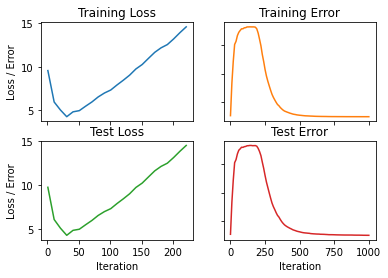

In [100]:
# GRAPHING
# gradient descent
trLossGD = [
    multinomial_logreg_batch_loss(Xs_tr, Ys_tr, 0.0001, weight)
    for weight in paramHist
]
trErrorGD = [multinomial_logreg_error(Xs_tr, Ys_tr, weight) for weight in paramHist]
teLossGD = [
    multinomial_logreg_batch_loss(Xs_te, Ys_te, 0.0001, weight)
    for weight in paramHist
]
teErrorGD = [multinomial_logreg_error(Xs_te, Ys_te, weight) for weight in paramHist]
iters = [(10 * i + 1) for i in range(len(paramHist))]

fig, axs = pyplot.subplots(2, 2)
axs[0, 0].plot(iters, trLossGD)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(iters, trErrorGD, "tab:orange")
axs[0, 1].set_title("Training Error")
axs[1, 0].plot(iters, teLossGD, "tab:green")
axs[1, 0].set_title("Test Loss")
axs[1, 1].plot(iters, teErrorGD, "tab:red")
axs[1, 1].set_title("Test Error")

for ax in axs.flat:
    ax.set(xlabel="Iteration", ylabel="Loss / Error")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
pyplot.show()
